First, I'll read all vehicle and non-vehicle filepaths in separate arrays.

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC

%matplotlib inline

vehicles = glob.glob('vehicles/**/*.PNG', recursive=True)
non_vehicles = glob.glob('non-vehicles/**/*.PNG', recursive=True)

print('Vehicle images: {0}'.format(len(vehicles)))
print('Non-vehicle images: {0}'.format(len(non_vehicles)))

Vehicle images: 8792
Non-vehicle images: 8968


# 1. Dataset exploration

Print some examples from both datasets:

In [2]:
# function for plotting images in grid
def draw_images(images, rows, columns, suptitle=''):
    fig, axarr = plt.subplots(rows, columns, figsize=(18,6))
    plt.suptitle(suptitle)
    # Show images
    image_index = 0
    for i in range(rows):
        for j in range(columns):
            img = mpimg.imread(images[image_index])
            axarr[i, j].axis('off')
            axarr[i, j].imshow(img)
            image_index += 1

In [76]:
veh_samples = np.random.choice(vehicles, 20)
non_samples = np.random.choice(non_vehicles, 20)

Image shape is: (64, 64, 3)


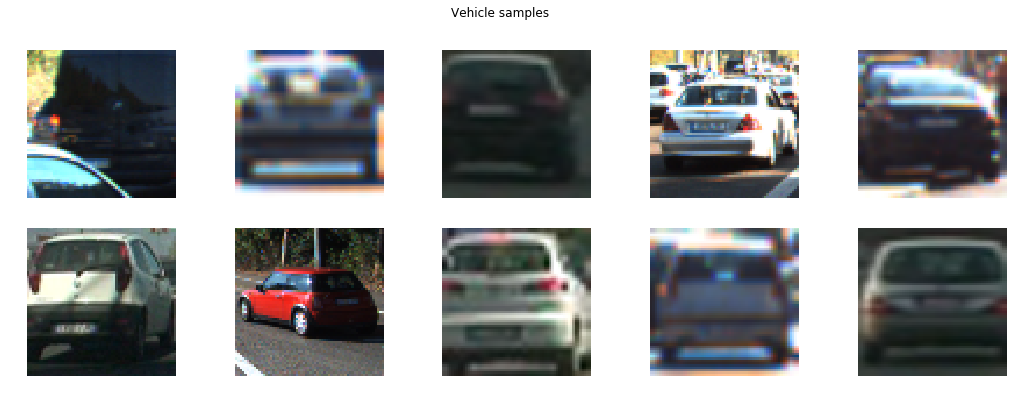

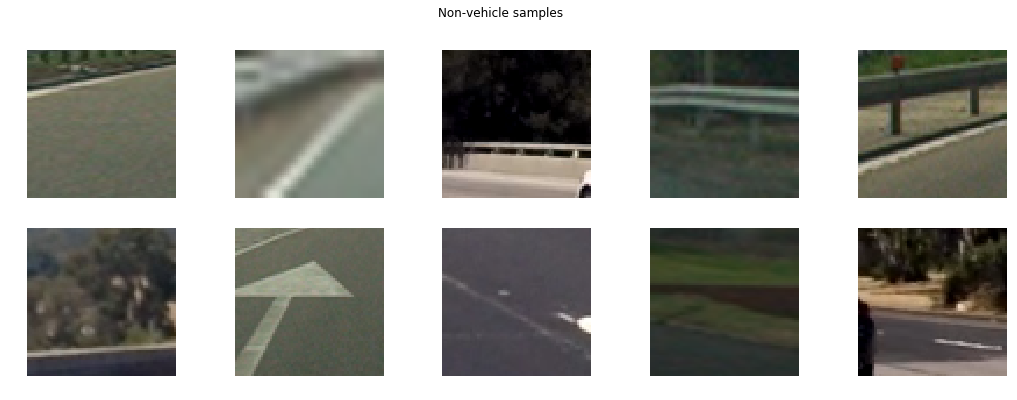

In [77]:
draw_images(veh_samples, 2, 5, 'Vehicle samples')
draw_images(non_samples, 2, 5, 'Non-vehicle samples')
print('Image shape is: {0}'.format(mpimg.imread(veh_samples[0]).shape))

# 2. Feature extraction.

## 2.1. Spatial binning

First I want to perform spatial binning on an image to retain information about to help in finding vehicles

In [78]:
# function to compute binned color features  
def bin_spatial(img, size=(24, 24)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# function for plotting histograms in grid
def draw_hist(features, rows, columns, suptitle = ''):
    fig, axarr = plt.subplots(rows, columns, figsize=(18,6))
    plt.suptitle(suptitle)
    # Show images
    feat_index = 0
    for i in range(rows):
        for j in range(columns):
            x = features[feat_index]
            #axarr[i, j].axis('off')
            axarr[i, j].hist(x, 30)
            feat_index += 1

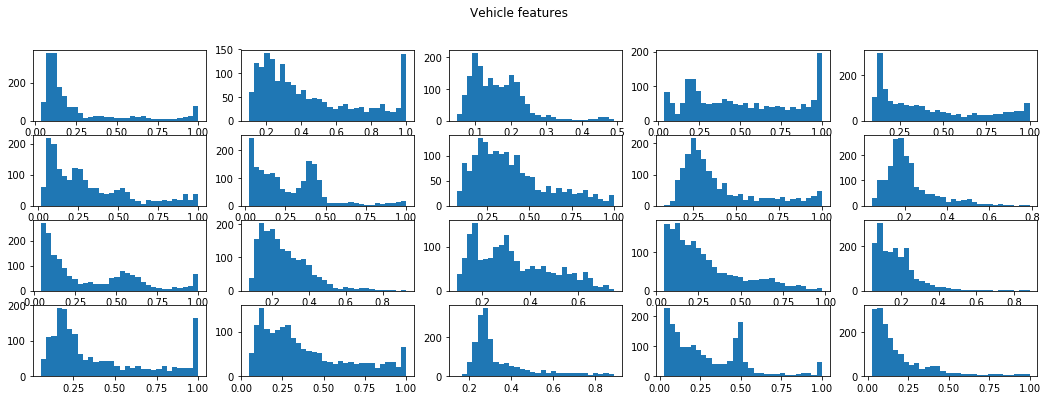

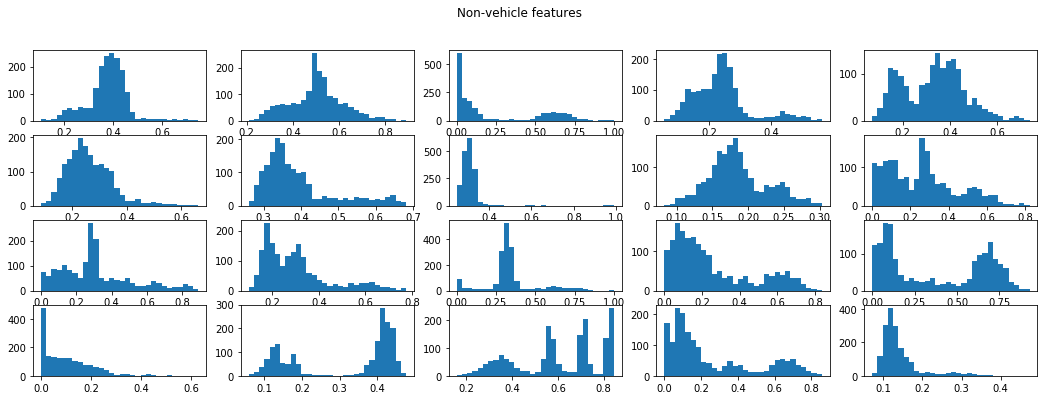

In [79]:
veh_features = []
non_features = []
for sample in veh_samples:
    veh_features.append(bin_spatial(mpimg.imread(sample)))
draw_hist(veh_features, 4, 5, 'Vehicle features')

for sample in non_samples:
    non_features.append(bin_spatial(mpimg.imread(sample)))
draw_hist(non_features, 4, 5, 'Non-vehicle features')

The car histograms seem to have roughly similar forms, and the histograms of all other road stuff vary a lot.
But I want to take a closer look at typical car image and histogram in comparison with typical non-car.

(array([   5.,    4.,    7.,   21.,   23.,   40.,   58.,   78.,   84.,
          80.,   96.,  105.,  119.,  117.,   99.,   88.,   94.,   66.,
          63.,   79.,   66.,   69.,   67.,   41.,   22.,   17.,   18.,
           7.,   10.,    7.,    8.,   12.,    3.,    5.,    7.,    6.,
           7.,    5.,    3.,    2.,    4.,    0.,    4.,    2.,    1.,
           1.,    3.,    2.,    1.,    2.]),
 array([ 0.08562092,  0.09714379,  0.10866667,  0.12018955,  0.13171242,
         0.1432353 ,  0.15475818,  0.16628105,  0.17780393,  0.18932681,
         0.20084968,  0.21237256,  0.22389544,  0.23541831,  0.24694119,
         0.25846406,  0.26998694,  0.28150982,  0.29303269,  0.30455557,
         0.31607845,  0.32760132,  0.3391242 ,  0.35064708,  0.36216995,
         0.37369283,  0.38521571,  0.39673858,  0.40826146,  0.41978434,
         0.43130721,  0.44283009,  0.45435296,  0.46587584,  0.47739872,
         0.48892159,  0.50044447,  0.51196735,  0.52349022,  0.5350131 ,
         0.54653

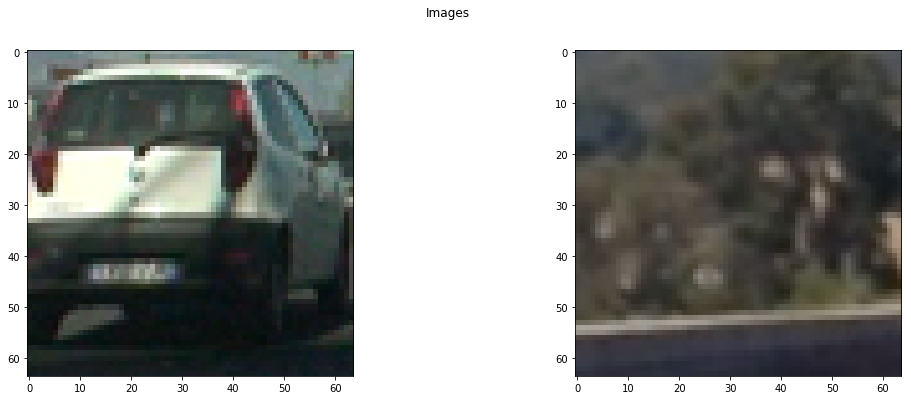

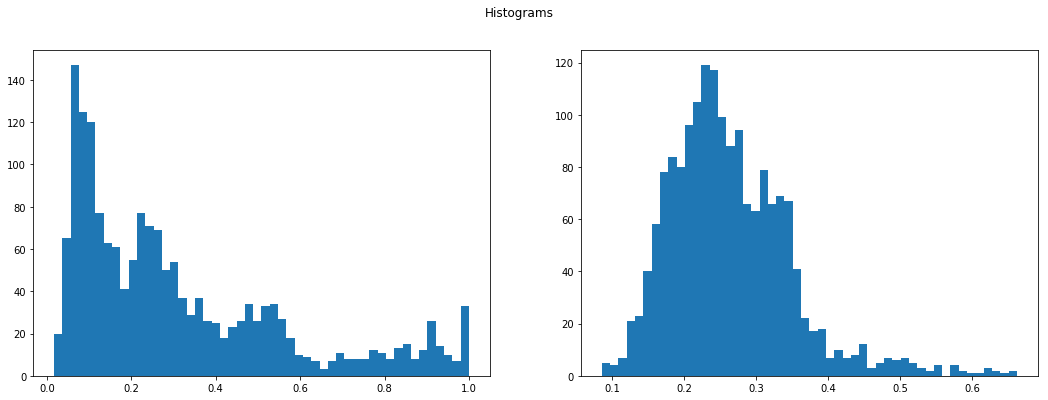

In [80]:
idx =5
fig, axarr = plt.subplots(1, 2, figsize=(18,6))
plt.suptitle('Images')
car_img = mpimg.imread(veh_samples[idx])
notcar_img = mpimg.imread(non_samples[idx])
axarr[0].imshow(car_img)
axarr[1].imshow(notcar_img)

fig, axarr = plt.subplots(1, 2, figsize=(18,6))
plt.suptitle('Histograms')
car_hist=bin_spatial(car_img)
notcar_hist=bin_spatial(notcar_img)
axarr[0].hist(car_hist, 50)
axarr[1].hist(notcar_hist, 50)
#plt.imshow(img)

So the histogram of the typical back of a car looks like exponential decay, and the road image's histograms are different but mostly they look more like normal distribution.
This feature seems to be useful for car detection.

## 2.2. Histograms of color

In [8]:

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
    
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
# define parameters
params = {}
params['cars'] = glob.glob('vehicles/**/*.PNG', recursive=True)
params['notcars'] = glob.glob('non-vehicles/**/*.PNG', recursive=True)
params['color_space'] = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
params['orient'] = 12  # HOG orientations
params['pix_per_cell'] = 8 # HOG pixels per cell
params['cell_per_block'] = 2 # HOG cells per block
params['hog_channel'] = "ALL" # Can be 0, 1, 2, or "ALL"
params['spatial_size'] = (16, 16) # Spatial binning dimensions
params['hist_bins'] = 16    # Number of histogram bins
params['spatial_feat'] = True # Spatial features on or off
params['hist_feat'] = True # Histogram features on or off
params['hog_feat'] = True # HOG features on or off

In [50]:
def get_features_by_params(params): 
    color_space=params['color_space']
    cars=params['cars']
    notcars=params['notcars']
    color_space=params['color_space']
    orient=params['orient']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    hog_channel=params['hog_channel']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins']
    spatial_feat=params['spatial_feat']
    hist_feat=params['hist_feat']
    hog_feat=params['hog_feat']
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=rand_state)
    X_scaled = []
    cars = []
    notcars = []
    car_features = []
    notcar_features = []
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    return X_train, X_test, y_train, y_test, X_scaler

# 3. Train classifier.
### 3.1. Common linear SVC

In [17]:
# Use a linear SVC 
X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
43.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9552


Now I want to try different parameters for feature extraction. Such as color space, number of orientations, pixels per cell etc.

In [19]:
color_spaces = ['HSV', 'HLS', 'YUV', 'YCrCb']
t=time.time()
for color_space in color_spaces:
    params['color_space'] = color_space
    print('Trying new params...')
    print('Color space = {0}'.format(params['color_space']))
    X_train, X_test, y_train, y_test,X_scaler = get_features_by_params(params)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    X_train = []
    X_test = []
    y_train = []
    y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Color space = HSV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.9778
Trying new params...
Color space = HLS
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.978
Trying new params...
Color space = YUV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.9851
Trying new params...
Color space = YCrCb
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.9817
678.19 Seconds to find parameters for feature extraction...


Well, looks like YUV scheme shows best results. But how does it look like?

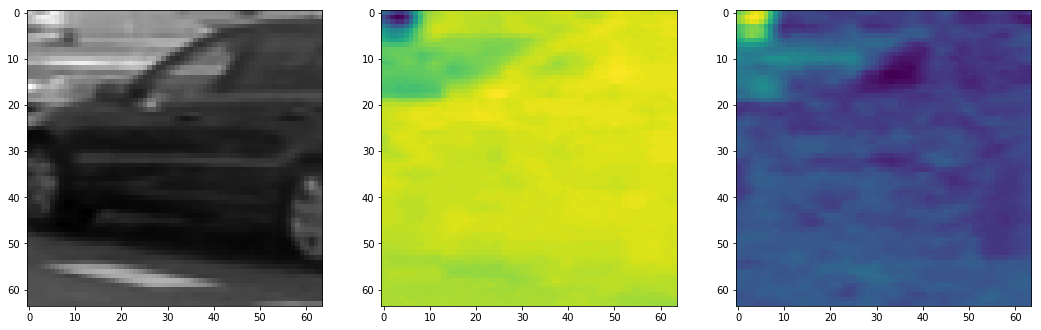

In [48]:
idx = 0
imgx=mpimg.imread(veh_samples[idx])
imgx = cv2.cvtColor(imgx, cv2.COLOR_RGB2YUV)
fig, axarr = plt.subplots(1, 3, figsize=(18,6))
axarr[0].imshow(imgx[:,:,0], cmap = 'gray')
axarr[1].imshow(imgx[:,:,1])
axarr[2].imshow(imgx[:,:,2])

Channels 1 and 2 look not very informative for my eye. I want to check how the classifier performs on different channels:

In [56]:
params['color_space'] = 'YUV'
hog_channels = [0,1,2,"ALL"]
t=time.time()
for hog_channel in hog_channels:
    params['hog_channel'] = hog_channel
    print('Trying new params...')
    print('Hog_channel = {0}'.format(params['hog_channel']))
    X_train, X_test, y_train, y_test,X_scaler = get_features_by_params(params)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    X_train = []
    X_test = []
    y_train = []
    y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Hog_channel = 0
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3168
Test Accuracy of SVC =  0.9586
Trying new params...
Hog_channel = 1
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3168
Test Accuracy of SVC =  0.9471
Trying new params...
Hog_channel = 2
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3168
Test Accuracy of SVC =  0.9583
Trying new params...
Hog_channel = ALL
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.9828
708.29 Seconds to find parameters for feature extraction...


Ok. Using all channes gives best result. But still channels 1 and 2 are suspicious. Maybe some of color schemes are better for different features.

In [45]:
# only bin
params['spatial_feat'] = True # Spatial features on or off
params['hist_feat'] = False # Histogram features on or off
params['hog_feat'] = False # HOG features on or off
color_spaces = ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']
t=time.time()
for color_space in color_spaces:
    params['color_space'] = color_space
    print('Trying new params...')
    print('Color space = {0}'.format(params['color_space']))
    X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    X_train = []
    X_test = []
    y_train = []
    y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Color space = RGB
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 768
Test Accuracy of SVC =  0.9127
Trying new params...
Color space = HSV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 768
Test Accuracy of SVC =  0.9051
Trying new params...
Color space = HLS
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 768
Test Accuracy of SVC =  0.8902
Trying new params...
Color space = YUV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 768
Test Accuracy of SVC =  0.9285
Trying new params...
Color space = YCrCb
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 768
Test Accuracy of SVC =  0.9305
163.74 Seconds to find parameters for feature extraction...


In [46]:
# only color
params['spatial_feat'] = False # Spatial features on or off
params['hist_feat'] = True # Histogram features on or off
params['hog_feat'] = False # HOG features on or off
color_spaces = ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']
t=time.time()
for color_space in color_spaces:
    params['color_space'] = color_space
    print('Trying new params...')
    print('Color space = {0}'.format(params['color_space']))
    X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    X_train = []
    X_test = []
    y_train = []
    y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Color space = RGB
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 48
Test Accuracy of SVC =  0.4958
Trying new params...
Color space = HSV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 48
Test Accuracy of SVC =  0.8238
Trying new params...
Color space = HLS
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 48
Test Accuracy of SVC =  0.8269
Trying new params...
Color space = YUV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 48
Test Accuracy of SVC =  0.5206
Trying new params...
Color space = YCrCb
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 48
Test Accuracy of SVC =  0.5051
149.51 Seconds to find parameters for feature extraction...


In [47]:
# only hog
params['spatial_feat'] = False # Spatial features on or off
params['hist_feat'] = False # Histogram features on or off
params['hog_feat'] = True # HOG features on or off
color_spaces = ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']
t=time.time()
for color_space in color_spaces:
    params['color_space'] = color_space
    print('Trying new params...')
    print('Color space = {0}'.format(params['color_space']))
    X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    X_train = []
    X_test = []
    y_train = []
    y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Color space = RGB
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
Test Accuracy of SVC =  0.9274
Trying new params...
Color space = HSV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
Test Accuracy of SVC =  0.9479
Trying new params...
Color space = HLS
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
Test Accuracy of SVC =  0.9519
Trying new params...
Color space = YUV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
Test Accuracy of SVC =  0.9578
Trying new params...
Color space = YCrCb
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
Test Accuracy of SVC =  0.9555
886.11 Seconds to find parameters for feature extraction...


So the YUV and YCrCb formats are almost senseless to color features. But the HLS format is good for it. Taking this into account, the feature extraction function must look like this.

In [11]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Extract spatial features using YCrCb scheme
        if spatial_feat == True:
            feature_image_spatial = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            spatial_features = bin_spatial(feature_image_spatial, size=spatial_size)
            file_features.append(spatial_features)
            
        # Extract color features using HLS scheme
        if hist_feat == True:
            # Apply color_hist()
            feature_image_color = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            hist_features = color_hist(feature_image_color, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image_hog.shape[2]):
                    hog_features.append(get_hog_features(feature_image_hog[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image_hog[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [58]:
params['spatial_feat'] = True # Spatial features on or off
params['hist_feat'] = True # Histogram features on or off
params['hog_feat'] = True # HOG features on or off
t=time.time()

print('Trying new params...')
print('Color space = {0}'.format(params['color_space']))
X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
X_train = []
X_test = []
y_train = []
y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Color space = YUV
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.9862
171.72 Seconds to find parameters for feature extraction...


Now I'll try some different orientations and numbers of pixels per cell

In [59]:
params['color_space'] = 'YUV'
ppcs = [8,16,24,32]
orients = [9,12]
t=time.time()
for ppc in ppcs:
    for orient in orients:
        params['pix_per_cell'] = ppc
        params['orient'] = orient
        print('Trying new params...')
        X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        X_train = []
        X_test = []
        y_train = []
        y_test = []
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find parameters for feature extraction...')

Trying new params...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
Test Accuracy of SVC =  0.9806
Trying new params...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
Test Accuracy of SVC =  0.9834
Trying new params...
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1788
Test Accuracy of SVC =  0.9834
Trying new params...
Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2112
Test Accuracy of SVC =  0.9876
Trying new params...
Using: 9 orientations 24 pixels per cell and 2 cells per block
Feature vector length: 924
Test Accuracy of SVC =  0.955
Trying new params...
Using: 12 orientations 24 pixels per cell and 2 cells per block
Feature vector length: 960
Test Accuracy of SVC =  0.9634
Trying new params...
Using: 9 orientations 32 pixels per cell and 2 cells per block
Feature vector length: 924
Test Accuracy of SVC =  0.9707
Tr

So the number of pixels per cell must be 16 and the number of orientation - 12

In [51]:
params['pix_per_cell'] = 16
params['orient'] = 12
params['hist_bins'] = 16
X_train, X_test, y_train, y_test, X_scaler = get_features_by_params(params)

Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2112


### 3.2. Linear SVC with parameter tuning.

In [60]:
from sklearn.model_selection import GridSearchCV
svc1 = LinearSVC()

parameters = {'C': [0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(svc1, parameters)
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))


Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2112
83.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9887


### 3.3. Trying different classifier

In [42]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(learning_rate_init = 0.0001, max_iter=500)
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train MLP...')
# Check the score of the MLP
print('Test Accuracy of MLP = ', round(mlp.score(X_test, y_test), 4))

265.44 Seconds to train MLP...
Test Accuracy of MLP =  0.9961


Building confusion matrix

In [46]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pred = mlp.predict(X_test)
matrix = pd.DataFrame(confusion_matrix(y_test,pred))
matrix

,0,1
0,1797,3
1,11,1741


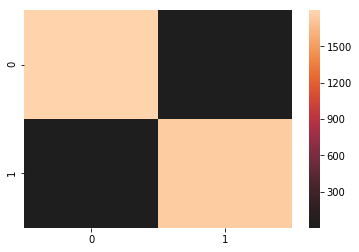

In [47]:
import seaborn as sns
sns.heatmap(matrix, center=True)
plt.show()

This classifier looks nice.

# 4. Detection pipeline

## 4.1 Pipeline for single image

In [57]:
# function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    file_features = []
    # Read in each one by one
    #image = mpimg.imread(file)

    # Extract spatial features using YCrCb scheme
    if spatial_feat == True:
        feature_image_spatial = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        spatial_features = bin_spatial(feature_image_spatial, size=spatial_size)
        file_features.append(spatial_features)

    # Extract color features using HLS scheme
    if hist_feat == True:
        # Apply color_hist()
        feature_image_color = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        hist_features = color_hist(feature_image_color, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
        feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image_hog.shape[2]):
                hog_features.append(get_hog_features(feature_image_hog[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image_hog[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    return np.concatenate(file_features)

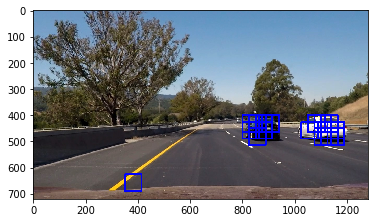

In [73]:
image = mpimg.imread('test6.jpg')
draw_image = np.copy(image)
y_start_stop = [350, 700] # Min and max in y to search in slide_window()
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.6, 0.6))

hot_windows = search_windows(image, windows, mlp, X_scaler, color_space=params['color_space'], 
                        spatial_size=params['spatial_size'], hist_bins=params['hist_bins'], 
                        orient=params['orient'], pix_per_cell=params['pix_per_cell'], 
                        cell_per_block=params['cell_per_block'], 
                        hog_channel=params['hog_channel'], spatial_feat=params['spatial_feat'], 
                        hist_feat=params['hist_feat'], hog_feat=params['hog_feat'])                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [122]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1800
8.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9488


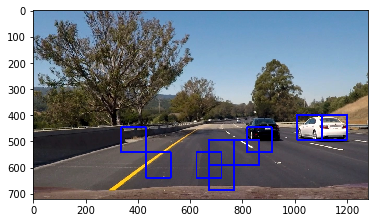

In [200]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
cars = glob.glob('vehicles/**/*.PNG', recursive=True)
notcars = glob.glob('non-vehicles/**/*.PNG', recursive=True)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 12    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)